In [1]:
import numpy as np
import pandas as pd
import sys,os

def load_files(batch):
    images = []
    labels = []
    for i in batch:
        print('Loading File: ' + i)
        x = np.load(i,encoding = 'latin1',allow_pickle=True).item()
        keys = x.keys()
        for key in keys:
            images.append(x[key][0])
            labels.append(x[key][1])
    return np.array(images),np.array(labels)

def get_feature(labels,feature):
    feature_values = []
    for i in labels:
        feature_values.append(i[feature])
    feature_values = np.array(feature_values)
    return feature_values

def get_cos_values(zenith,azimuth):
    cos1 = []
    cos2 = []
    cos3 = []
    for i,j in zip(zenith,azimuth):
        cos1.append(np.sin(i) * np.cos(j))
        cos2.append(np.sin(i) * np.sin(j))
        cos3.append(np.cos(i))
    return np.array(cos1),np.array(cos2),np.array(cos3)

In [2]:
file_path = '/fs/scratch/PAS1495/amedina/'
y = os.listdir(file_path+'processed_simple')

file_names = []

for i in y:
    file_names.append(file_path+'processed_simple/'+i)

file_names_batched = list(np.array_split(file_names,300))

In [3]:
images1,labels = load_files(file_names_batched[0])

Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_5958.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_207.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_5774.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_5256.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_4768.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_2519.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_4632.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_5356.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_4155.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_5633.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_4163.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_7039.npy
Loading File: /fs/scratch/PAS1495/amedina/processed_simple/images_6819.npy
Loading File: /fs/scratch/

In [4]:
images = images1[:,:,:,:]
#images = images1


zenith_values = get_feature(labels,1)
azimuth_values = get_feature(labels,2)

zenith_direction = []

for i in zenith_values:
    if i < np.pi/2.0:
        zenith_direction.append(-1)
    if i >= np.pi/2.0:
        zenith_direction.append(1)

cos1,cos2,cos3 = get_cos_values(zenith_values,azimuth_values)

In [5]:
import tensorflow as tf

import keras
from keras.models import Sequential,load_model, Model
from keras.layers import Dense, Dropout, Flatten, Input,InputLayer, Concatenate
from keras.layers import SeparableConv2D, MaxPooling2D , GaussianNoise,BatchNormalization
from keras import backend as K
from sklearn.model_selection import train_test_split,KFold
from keras.layers import LeakyReLU,GaussianDropout,Lambda,UpSampling1D, LSTM
from keras import regularizers

Using TensorFlow backend.


In [7]:
cos_values = np.array(list(zip(cos1,cos2,cos3,zenith_direction)))
cos_values1 = np.zeros([len(cos_values),len(cos_values[0])])
for i in range(len(cos_values)):
    for j in range(len(cos_values[0])):
        cos_values1[i][j]=(cos_values[i][j] + 1.0)/2.0
print(cos_values1)

[[0.60534236 0.01458017 0.44281103 1.        ]
 [0.12694781 0.79961908 0.64512226 0.        ]
 [0.82456251 0.27577657 0.80721822 0.        ]
 ...
 [0.05406233 0.32880662 0.64775798 0.        ]
 [0.33655306 0.92165617 0.7132866  0.        ]
 [0.69700136 0.94558757 0.38756254 1.        ]]


In [16]:
def get_data(images,values):
    x_train, x_test , y_train , y_test = train_test_split(np.array(images),values,test_size = 0.1 , random_state=42)
    return x_train,x_test,y_train,y_test

x_train,x_test,y_train,y_test = get_data(images,cos_values1)

In [17]:
def loss_space_angle(y_true,y_pred):
    y_true1 = y_true*2.0-1.0
    y_pred1 = y_pred*2.0-1.0
    subtraction = tf.math.subtract(y_true1,y_pred1)
    y = tf.matrix_diag_part(K.dot(subtraction,K.transpose(subtraction)))
    loss = tf.math.reduce_mean(y)
    return loss


In [18]:
number_features = 9

img_heights,img_rows = 60,86

kernel = 3
kernel2 = 2

model1_input = Input(shape=(number_features,img_heights,img_rows))

model1 = LeakyReLU(alpha = 0.01)(model1_input)
output1 = MaxPooling2D(kernel2,padding='same',data_format='channels_first')(model1)
model1 = SeparableConv2D(32,kernel,padding='same',kernel_regularizer=regularizers.l2(0.01),data_format='channels_first')(output1)

model1 = LeakyReLU(alpha = 0.01)(model1)
output2 = MaxPooling2D(kernel2,padding='same',data_format='channels_first')(model1)
model1 = SeparableConv2D(32,kernel,padding='same',kernel_regularizer=regularizers.l2(0.01),data_format='channels_first')(output2)

model1 = LeakyReLU(alpha = 0.01)(model1)
output3 = MaxPooling2D(kernel2,padding='same',data_format='channels_first')(model1)
model1 = SeparableConv2D(32,kernel,padding='same',kernel_regularizer=regularizers.l2(0.01),data_format='channels_first')(output3)

cnn_model1 = Flatten()(model1_input)
cnn_model2 = Flatten()(model1)
cnn_model3 = Flatten()(output1)
cnn_model4 = Flatten()(output2)
cnn_model5 = Flatten()(output3)
cnn_model = Concatenate(axis=-1)([cnn_model1,
                                cnn_model2,
                                cnn_model3,
                                cnn_model4,
                                cnn_model5
                                ])


cnn_model = Model(inputs=model1_input,outputs=cnn_model)
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-5, amsgrad=False)
cnn_model.compile(optimizer=opt , loss = loss_space_angle)

print(cnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 9, 60, 86)    0                                            
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 9, 60, 86)    0           input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 9, 30, 43)    0           leaky_re_lu_6[0][0]              
__________________________________________________________________________________________________
separable_conv2d_4 (SeparableCo (None, 32, 30, 43)   401         max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
leaky_re_l

In [19]:
input_new = Input(shape=(number_features,img_heights,img_rows))

output = Lambda(lambda x: cnn_model(x))(input_new)

model = Dropout(0.5)(output)
model = Dense(512)(model)
model = LeakyReLU(alpha = 0.01)(model)
model = Dropout(0.5)(model)
model = Dense(512)(model)
model = LeakyReLU(alpha = 0.01)(model)

input_new_prime = Flatten()(input_new)
model = Concatenate(axis=-1)([model, input_new_prime])

predictions = Dense(4)(model)

model = Model(inputs=input_new,outputs=predictions)
opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-5, amsgrad=False)
model.compile(optimizer=opt , loss = loss_space_angle)

print(model.summary())
    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 9, 60, 86)    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 74242)        0           input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 74242)        0           lambda_2[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          38012416    dropout_3[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

In [20]:
#keras.utils.plot_model(cnn_model, to_file='cnn_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')
#keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')
np.array(zip(*x_train)[0]).shape


(979, 60, 86)

In [21]:
history1 = []
history2 = []
batch_size = 128
epochs=40


history=model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test))
history_dict = history.history
history1.append(history_dict['loss'])
history2.append(history_dict['val_loss'])


Train on 979 samples, validate on 109 samples
Epoch 1/40
979/979 [==============================] - 3s 3ms/step - loss: 3.1321 - val_loss: 1.8578
Epoch 2/40
979/979 [==============================] - 2s 2ms/step - loss: 1.6778 - val_loss: 1.5649
Epoch 3/40
979/979 [==============================] - 2s 2ms/step - loss: 1.2776 - val_loss: 1.3459
Epoch 4/40
979/979 [==============================] - 2s 2ms/step - loss: 0.9980 - val_loss: 1.2112
Epoch 5/40
979/979 [==============================] - 2s 2ms/step - loss: 0.7865 - val_loss: 1.0475
Epoch 6/40
979/979 [==============================] - 2s 2ms/step - loss: 0.6274 - val_loss: 0.8934
Epoch 7/40
979/979 [==============================] - 2s 2ms/step - loss: 0.4824 - val_loss: 0.7769
Epoch 8/40
979/979 [==============================] - 2s 2ms/step - loss: 0.3634 - val_loss: 0.6406
Epoch 9/40
979/979 [==============================] - 2s 2ms/step - loss: 0.2858 - val_loss: 0.5754
Epoch 10/40
979/979 [==============================] -

In [14]:
#import matplotlib.pyplot as plt
#history_dict = history.history
#print(history_dict.keys())
#loss_values = history_dict['loss']
#val_loss_values = history_dict['val_loss']

#epochs = range(1, len(loss_values)+1)

#start = 2

#plt.plot(epochs[start:len(epochs)],loss_values[start:len(loss_values)],'bo',label='Training loss')
#plt.plot(epochs[start:len(epochs)],val_loss_values[start:len(val_loss_values)],'b',label='Validation loss')
#plt.title('Training and validation loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()

#plt.show()

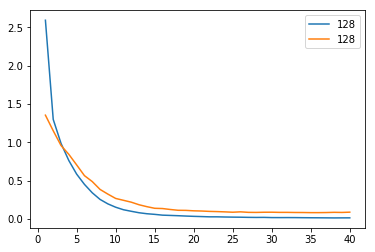

In [17]:
import matplotlib.pyplot as plt
labels = ['128']
count = 0
count1 = 0
epochs = range(1, len(history1[0])+1)
plt.figure()
for i in history1:
    plt.plot(epochs,i,label = labels[count])
    count+=1
for j in history2:
    plt.plot(epochs,j,label=labels[count1])
    count1+=1
plt.legend()
plt.show()

In [16]:
#plt.savefig('figure.png')